In [ ]:
#! pip install refractml 
#! pip freeze | grep -i refractml
! pip uninstall -y urllib3


In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from refractml import *
from refractml.constants import MLModelFlavours

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
data = pd.read_csv("/data/fifa.csv")
data.head(10)

short_name  nationality  overall  potential  wage_eur  value_eur  \
0           L. Messi    Argentina       94         94    565000   95500000   
1  Cristiano Ronaldo     Portugal       93         93    405000   58500000   
2          Neymar Jr       Brazil       92         92    290000  105500000   
3           J. Oblak     Slovenia       91         93    125000   77500000   
4          E. Hazard      Belgium       91         91    470000   90000000   
5       K. De Bruyne      Belgium       91         91    370000   90000000   
6      M. ter Stegen      Germany       90         93    250000   67500000   
7        V. van Dijk  Netherlands       90         91    200000   78000000   
8          L. Modric      Croatia       90         90    340000   45000000   
9           M. Salah        Egypt       90         90    240000   80500000   

   age  height_cm  weight_kg  attacking_crossing  ...  mentality_penalties  \
0   32        170         72                  88  ...                   75   
1   34        187         83                  84  ...                   85   
2   27        175         68                  87  ...                   90   
3   26        188         87                  13  ...                   11   
4   28        175         74                  81  ...                   88   
5   28        181         70                  93  ...                   79   
6   27        187         85                  18  ...                   25   
7   27        193         92                  53  ...                   62   
8   33        172         66                  86  ...                   82   
9   27        175         71                  79  ...                   77   

   mentality_composure  defending_marking  defending_standing_tackle  \
0                   96                 33                         37   
1                   95                 28                         32   
2                   94                 27                         26   
3                   68                 27                         12   
4                   91                 34                         27   
5                   91                 68                         58   
6                   70                 25                         13   
7                   89                 91                         92   
8                   92                 68                         76   
9                   91                 38                         43   

   defending_sliding_tackle  goalkeeping_diving  goalkeeping_handling  \
0                        26                   6                    11   
1                        24                   7                    11   
2                        29                   9                     9   
3                        18                  87                    92   
4                        22                  11                    12   
5                        51                  15                    13   
6                        10                  88                    85   
7                        85                  13                    10   
8                        71                  13                     9   
9                        41                  14                    14   

   goalkeeping_kicking  goalkeeping_positioning  goalkeeping_reflexes  
0                   15                       14                     8  
1                   15                       14                    11  
2                   15                       15                    11  
3                   78                       90                    89  
4                    6                        8                     8  
5                    5                       10                    13  
6                   88                       88                    90  
7                   13                       11                    11  
8                    7                       14

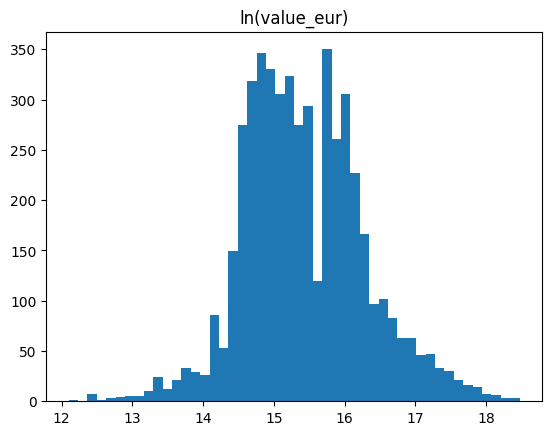

In [3]:
X = data[['age','height_cm','weight_kg','skill_dribbling','attacking_crossing','attacking_finishing','movement_acceleration','movement_sprint_speed','power_shot_power','mentality_aggression','defending_marking','defending_standing_tackle','goalkeeping_diving','goalkeeping_handling','overall','potential']]
y = data['value_eur']
ylog = np.log(y)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=4)

In [4]:
gbm_default = GradientBoostingRegressor()
gbm_default.fit(X_train, y_train)

GradientBoostingRegressor()

In [5]:
@scoring_func
def score(model, request):
    payload = request.json["payload"]
    data_list = payload
    data_array = np.asarray(data_list)
    try:
        prediction = model.predict(data_array)
    except:
        prediction = model.predict(data_array.reshape(1, -1))
    return prediction.tolist()

In [6]:
# to verify if score func works

import requests
req = requests.Request()
req.json = {"payload":X_test}

'''
Reference Sample Payload 

req.json = {"payload": [ 25, 185,  88,  78,  65,  81,  77,  75,  81,  63,  37,  26,   9,
        10,  79,  82]}
        
'''
score(gbm_default, req)

[7371874.661681471,
 4738569.183719677,
 21420646.724212054,
 18565368.23481532,
 2521068.4565907386,
 4927893.686116413,
 17717792.640952602,
 536649.2767679197,
 5379405.813943997,
 2782661.6857576403,
 3109098.8043037453,
 3854078.968972358,
 4098721.556383506,
 7769807.652539339,
 4692304.372048862,
 16930281.548238754,
 3473019.661723151,
 6661265.394274319,
 3016063.3275525454,
 10421430.298660975,
 1978920.7122082578,
 2802425.78018358,
 905938.3801071703,
 7703026.231638119,
 4737163.454637369,
 9200545.134584036,
 40671774.99537543,
 11732600.005104974,
 11769365.628129426,
 127060.88757149612,
 5192798.597258344,
 3933793.166518539,
 2461772.7940336005,
 17703016.395034228,
 5660456.160853361,
 2502423.505083094,
 6259869.183645458,
 8698457.579092516,
 1833849.8102294577,
 4711891.25781507,
 2820859.9746349403,
 2385315.894151529,
 1986428.045896929,
 7220836.170301254,
 2028027.9431738032,
 1953495.1905439,
 3606521.7807429773,
 2197176.334081367,
 6941085.884180224,
 56048

In [7]:
Y_true = y_test

Y_pred = gbm_default.predict(X_test)
features = list(X_train)

In [11]:
register_model(
    gbm_default,
    score,
    "fifa_model_v1_py39",
    "fifa_regression",
    MLModelFlavours.sklearn,
    init_script="mkdir abc \\n cd abc \\n touch abc.txt",
    input_type="json",
    explain_ai=True,
    x_train=X_train, 
    y_train=y_train, 
    y_true=Y_true,
    y_pred=Y_pred,
    feature_names=features,
    feature_ids=features,
    target_names=["Value"],
    model_type="regression"
)

Calculating build time metrics

Progress: ██████████████████████████████████████████████████████████████████████ 100.0%


In [9]:
features

['age',
 'height_cm',
 'weight_kg',
 'skill_dribbling',
 'attacking_crossing',
 'attacking_finishing',
 'movement_acceleration',
 'movement_sprint_speed',
 'power_shot_power',
 'mentality_aggression',
 'defending_marking',
 'defending_standing_tackle',
 'goalkeeping_diving',
 'goalkeeping_handling',
 'overall',
 'potential']